## Analysing Smartwatch Data

This notebook gives an overview of how to use HeartPy in the analysis of raw PPG data taken from a commercial (Samsung) smartwatch device.

A signal measured this way contains a lot more noise when compared to a typical PPG sensor on the fingertip or earlobe, where perfusion is much easier to measure than on the wrist.

Analysing such a signal requires some additional steps as described in this notebook.

First let's load up the dependencies and the data file

In [1]:
import numpy as np

import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('raw_ppg.csv')

In [2]:
df.keys()

Index(['ppg', 'timer'], dtype='object')

#### Exploring data file

Let's explore the data file to get an idea of what we're working with.

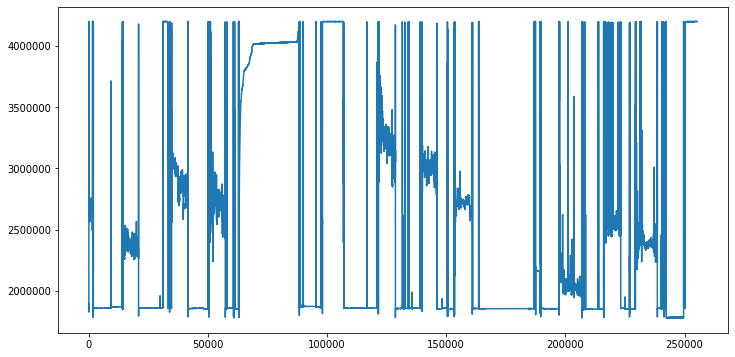

In [3]:
plt.figure(figsize=(12,6))

plt.plot(df['ppg'].values)
plt.show()

#### Ok..

There seems to be intermittent sections of PPG dotted between non-signals (periods where the sensor was not recording). 

For now let's slice the first signal section and see what's up. Later on I'll show you how to exclude non-signal sections automatically.

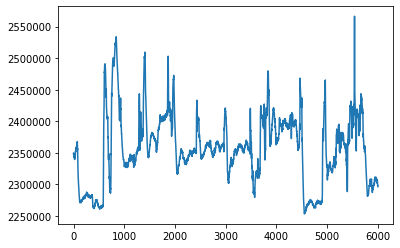

In [4]:
signal = df['ppg'].values[14500:20500]
timer = df['timer'].values[14500:20500]
plt.plot(signal)
plt.show()

#### Now we need to know the sampling rate

The sampling rate is the one measure to rule them all. It is used to compute all others.

HeartPy has several ways of getting the sample rate from timer columns. Let's look at the format of the timer column to see what we're working with.

In [5]:
timer[0:20]

array(['11:10:57.978', '11:10:58.078', '11:10:58.178', '11:10:58.279',
       '11:10:58.379', '11:10:58.479', '11:10:58.579', '11:10:58.679',
       '11:10:58.779', '11:10:58.879', '11:10:58.980', '11:10:59.092',
       '11:10:59.180', '11:10:59.283', '11:10:59.381', '11:10:59.481',
       '11:10:59.582', '11:10:59.681', '11:10:59.781', '11:10:59.882'],
      dtype=object)

So, the format seems to be **'hours:minutes:seconds.miliseconds'**

HeartPy comes with a datetime function that can work with date- and time-strings called *get_samplerate_datetime*. Check the help to see how it works:

In [6]:
help(hp.get_samplerate_datetime)

Help on function get_samplerate_datetime in module heartpy.datautils:

get_samplerate_datetime(datetimedata, timeformat='%H:%M:%S.%f')
    determine sample rate based on datetime
    
    Function to determine sample rate of data from datetime-based timer
    list or array.
    
    Parameters
    ----------
    timerdata : 1-d numpy array or list
        sequence containing datetime strings
    
    timeformat : string
        the format of the datetime-strings in datetimedata
        default : '%H:%M:%S.f' (24-hour based time including ms: e.g. 21:43:12.569)
    
    Returns
    -------
    out : float
        the sample rate as determined from the timer sequence provided
    
    Examples
    --------
    We load the data like before
    
    >>> data, timer = load_exampledata(example = 2)
    >>> timer[0]
    '2016-11-24 13:58:58.081000'
    
    Note that we need to specify the timeformat used so that datetime understands
    what it's working with:
    
    >>> round(get_samplera

In [7]:
#Seems easy enough, right? Now let's determine the sample rate

sample_rate = hp.get_samplerate_datetime(timer, timeformat = '%H:%M:%S.%f')

print('sampling rate is: %.3f Hz' %sample_rate)

sampling rate is: 9.986 Hz


### That's pretty low.

The sample rate is quite low but to conserve power this is what many smart watches work with. For determining the BPM this is just fine, but any heart rate variability (HRV) measures are likely not going to be super accurate. Depending on your needs it may still be fine, though.

A **second consideration** with sampling rate is whether it's stable or not. Many devices including smart watches do many things at once. They run an OS that has other tasks besides measuring heart rate, so when measuring at 10Hz, the OS might not be ready exactly every 100ms to get a measurement. As such, the sampling rate might vary. Let's visualise this. 

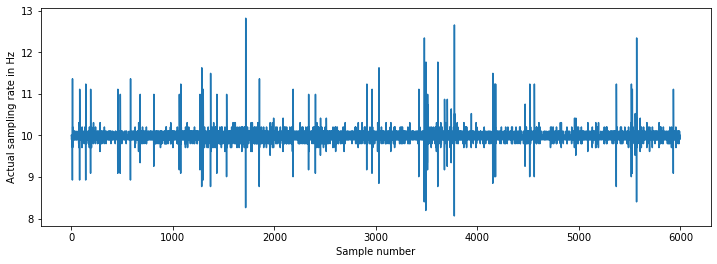

mean sampling rate: 9.987
median sampling rate: 10.000
standard deviation: 0.183


In [8]:
from datetime import datetime

#let's create a list 'newtimer' to house our datetime objects
newtimer = [datetime.strptime(x, '%H:%M:%S.%f') for x in timer]

#let's compute the real distances from entry to entry
elapsed = []
for i in range(len(newtimer) - 1):
    elapsed.append(1 / ((newtimer[i+1] - newtimer[i]).microseconds / 1000000))

#and plot the results
plt.figure(figsize=(12,4))
plt.plot(elapsed)
plt.xlabel('Sample number')
plt.ylabel('Actual sampling rate in Hz')
plt.show()

print('mean sampling rate: %.3f' %np.mean(elapsed))
print('median sampling rate: %.3f'%np.median(elapsed))
print('standard deviation: %.3f'%np.std(elapsed))

### That's actually not bad!

The signal mean is close to 10Hz and shows a low variance. Sporadic peaks to 12Hz or dips to 9Hz indicate timer inaccuracies but they are infrequent.

For our current purposes this is just fine.

You could of course interpolate and resample the signal so that it has an exact sampling rate but the effects on computed measures are likely minimal. For now let's just continue on.

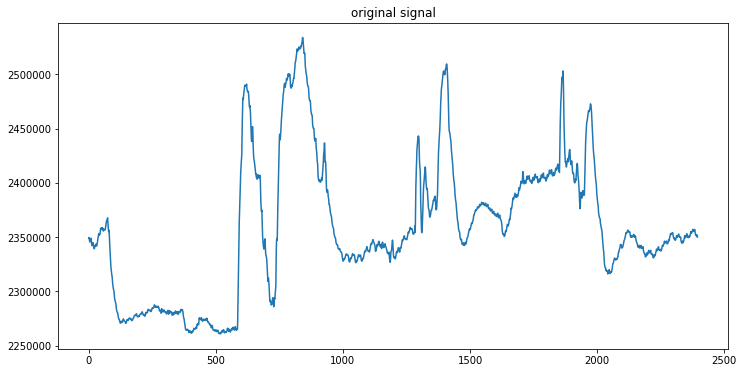

In [9]:
#Let's plot 4 minutes of the segment we selected to get a view 
#of what we're working with
plt.figure(figsize=(12,6))
plt.plot(signal[0:int(240 * sample_rate)])
plt.title('original signal')
plt.show()

The first thing to note is that amplitude varies dramatically. Let's run it through a bandpass filter and take out all frequencies that definitely are not heart rate.

We'll take out frequencies below 0.7Hz (42 BPM) and above 3.5 Hz (210 BPM). 

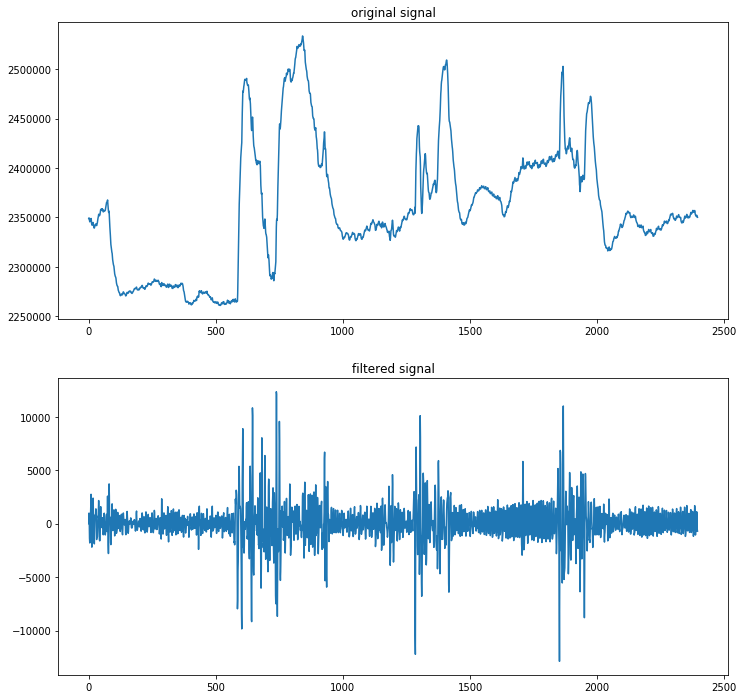

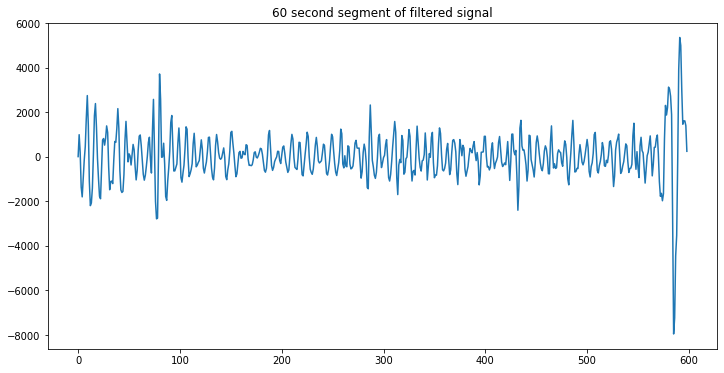

In [10]:
#Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
filtered = hp.filter_signal(signal, [0.7, 3.5], sample_rate=sample_rate, 
                            order=3, filtertype='bandpass')

#let's plot first 240 seconds and work with that!
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(signal[0:int(240 * sample_rate)])
plt.title('original signal')
plt.subplot(212)
plt.plot(filtered[0:int(240 * sample_rate)])
plt.title('filtered signal')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered[0:int(sample_rate * 60)])
plt.title('60 second segment of filtered signal')
plt.show()

#### Still low quality but at least the heart rate is quite visible now!

In [11]:
#let's resample to ~100Hz as well
#10Hz is low for the adaptive threshold analysis HeartPy uses
from scipy.signal import resample

resampled = resample(filtered, len(filtered) * 10)

#don't forget to compute the new sampling rate
new_sample_rate = sample_rate * 10

In [12]:
#run HeartPy over it, fingers crossed
wd, m = hp.process(resampled, sample_rate = new_sample_rate, 
                   high_precision=True, clean_rr=True)

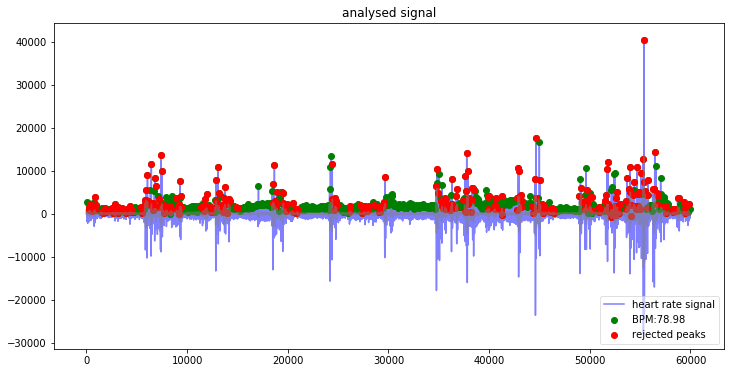

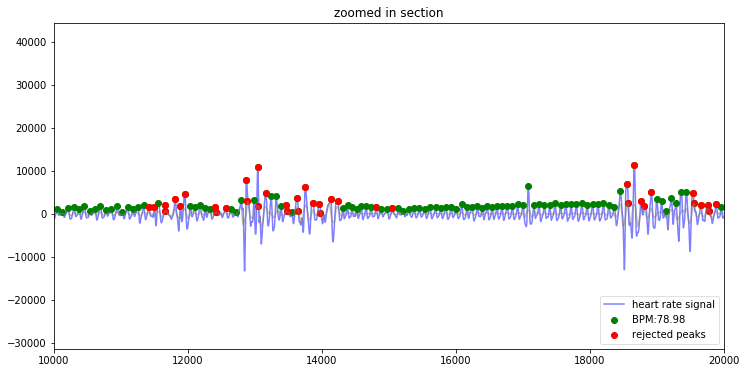

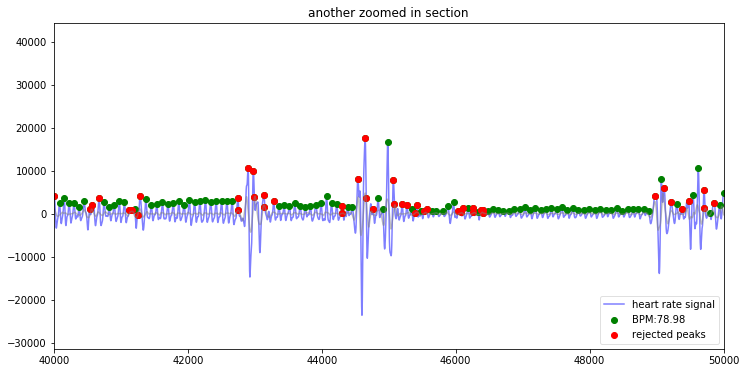

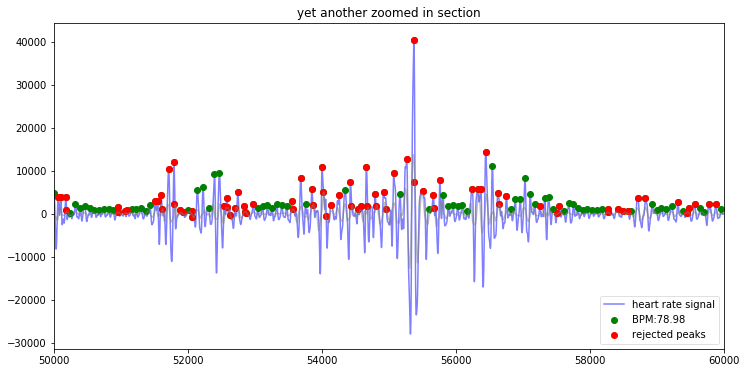

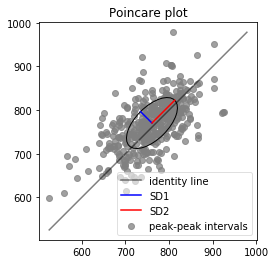

bpm: 78.981709
ibi: 759.669563
sdnn: 79.989043
sdsd: 99.586554
rmssd: 99.586688
pnn20: 0.385797
pnn50: 0.205374
hr_mad: 41.049817
sd1: 36.948123
sd2: 73.723698
s: 8557.548377
sd1/sd2: 0.501170
breathingrate: 0.239659


In [13]:
#and plot the result
plt.figure(figsize=(12,6))
hp.plotter(wd, m, title = 'analysed signal')

#zoom in a bit
plt.figure(figsize=(12,6))
plt.xlim(10000, 20000)
hp.plotter(wd, m, title = 'zoomed in section')

plt.figure(figsize=(12,6))
plt.xlim(40000, 50000)
hp.plotter(wd, m, title = 'another zoomed in section')

plt.figure(figsize=(12,6))
plt.xlim(50000, 60000)
hp.plotter(wd, m, title = 'yet another zoomed in section')

hp.plot_poincare(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### That seems a reasonable result. By far the most peaks are marked correctly, and most peaksin noisy sections (low confidence) are simply rejected.

clean_rr uses by default quotient-filtering, which is a bit aggressive.

You can set 'iqr' or 'z-score' with the clean_rr_method flag.

### Finally let's look at a way to extract signal section and exclude non-signal sections automatically.

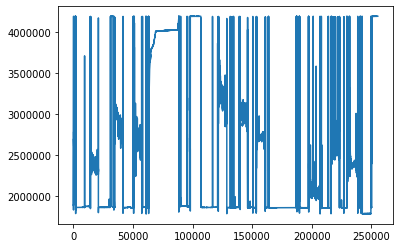

In [14]:
raw = df['ppg'].values

plt.plot(raw)
plt.show()

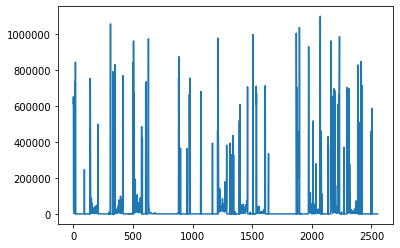

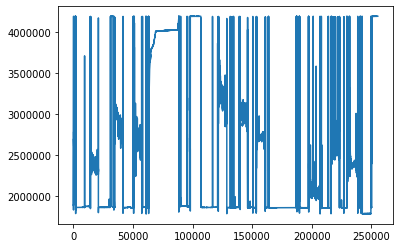

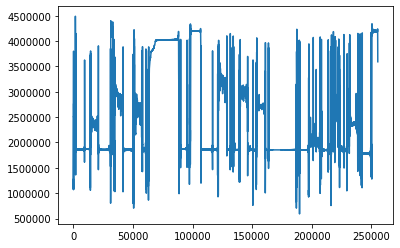

In [15]:
import sys
from scipy.signal import resample

windowsize = 100
std = []

for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    try:
        std.append(np.std(sliced))
    except:
        print(i)
    
plt.plot(std)
plt.show()

plt.plot(raw)
plt.show()

plt.plot(raw[0:(len(raw) // windowsize) * windowsize] - resample(std, len(std)*windowsize))
plt.show()

#### Hmmm, not much luck yet, but an idea:

In [16]:
(len(raw) // windowsize) * windowsize

255300

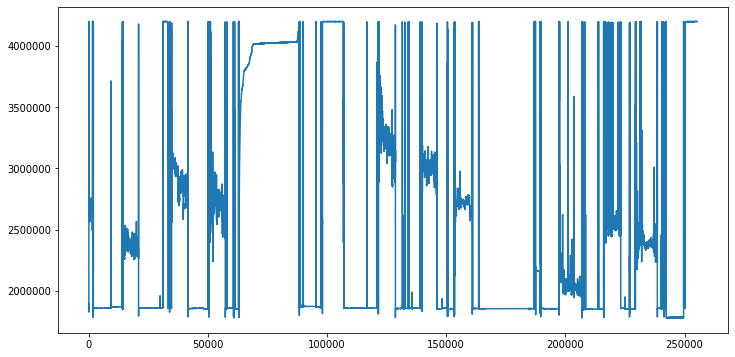

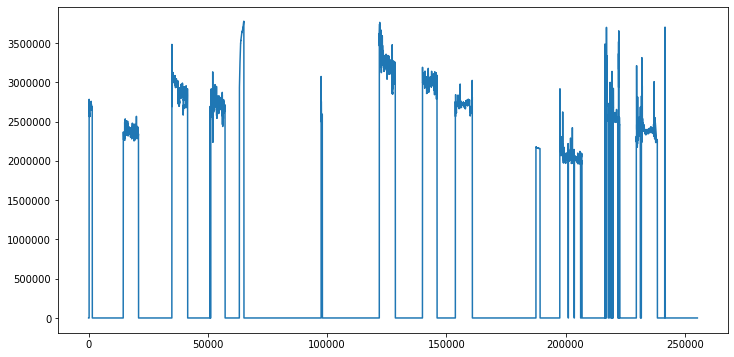

In [17]:
mx = np.max(raw)
mn = np.min(raw)
global_range = mx - mn

windowsize = 100
filtered = []

for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    rng = np.max(sliced) - np.min(sliced)
    
    if ((rng >= (0.5 * global_range)) 
        or 
        (np.max(sliced) >= 0.9 * mx) 
        or 
        (np.min(sliced) <= mn + (0.1 * mn))):
        
        for x in sliced:
            filtered.append(0)
    else:
        for x in sliced:
            filtered.append(x)
   
plt.figure(figsize=(12,6))
plt.plot(raw)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered)
plt.show()

### That works! A quick and dirty automatic extraction of signal sections

For this we use a window function and for each window test whether it:

-	Has a range that is at least 50% of range of the raw signal
-	OR
-	Has a maximum that is 90% the raw signal’s maximum
-	OR
-	Has a minimum that is the minimum + 10% of the raw signal

This works well enough